/home/apra/Projects/apra-howfsc-models/apra_pop_models


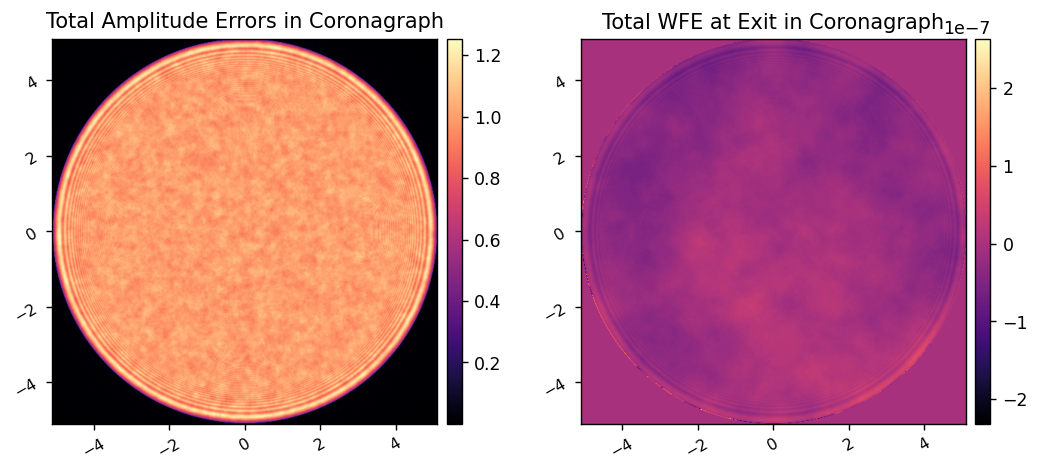

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_poppy as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array

import apra_pop_models.efc as efc
import apra_pop_models.pwp as pwp
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_embedded as efc

from apra_pop_models.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam *focal_ratio

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('../phase-retrieval-data/post_fpm_wfe_20231109.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'Total Amplitude Errors in Coronagraph', 'Total WFE at Exit in Coronagraph',
        pxscl=CORO_WFE.pixelscale.to(u.mm/u.pix))

vortex_model = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
lyot_stop_model = poppy.CircularAperture(radius=lyot_diam/2 / focal_ratio)


# Test the match between the full model and the compact model

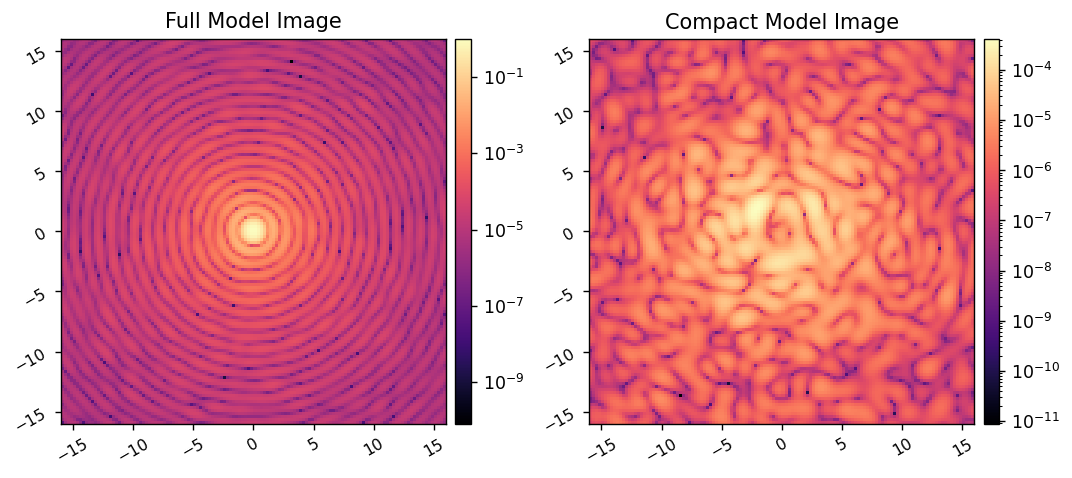

In [2]:
reload(fraunhofer)
reload(apra_pop_models.dm)
reload(apra_pop_models.agpm)

model = fraunhofer.CORO()
model.npix = 128
model.oversample = 16
model.npsf = 128
model.RETRIEVED = CORO_WFE

model.im_norm = model.snap().max()

model_psf = model.snap()

model.FPM = vortex_model
model.LYOT = lyot_stop_model

model_im = model.snap()

imshow2(model_psf, model_im, 'Full Model Image', 'Compact Model Image', lognorm=True,
        pxscl=model.psf_pixelscale_lamD)

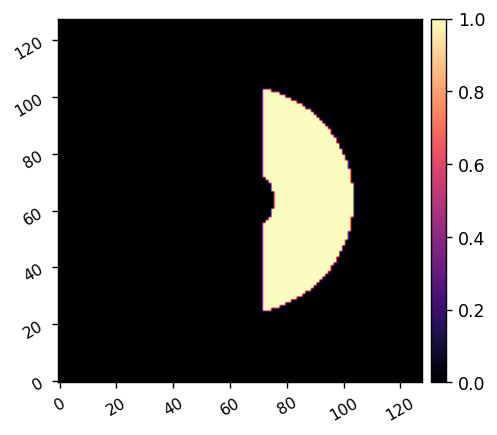

1828


In [3]:
control_mask = efc_utils.create_annular_focal_plane_mask(model, inner_radius=3, outer_radius=10, edge=2, plot=True)

Nmask = int(control_mask.sum())
print(Nmask)

In [4]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=274.059 sec.
Jacobian built in 274.059 sec


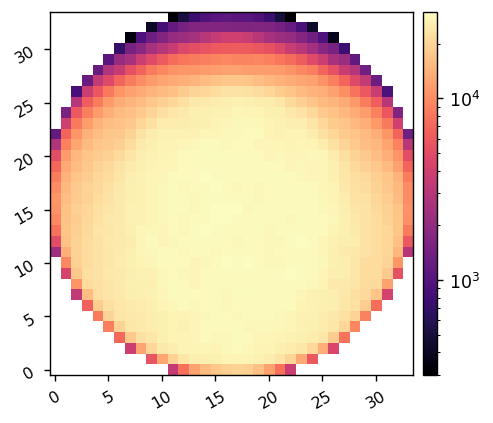

In [13]:
model.reset_dm()
coro.reset_dm()

amp = 1e-9 # poke amplitudes (DM surface)
jac = efc.calibrate(model, poke_modes, amp, control_mask, plot=True)

In [5]:
utils.save_fits('../jacobians/jac_20231115.fits', jac)

NameError: name 'utils' is not defined

In [6]:
jac = xp.array(fits.getdata('../jacobians/jac_20231115.fits'))

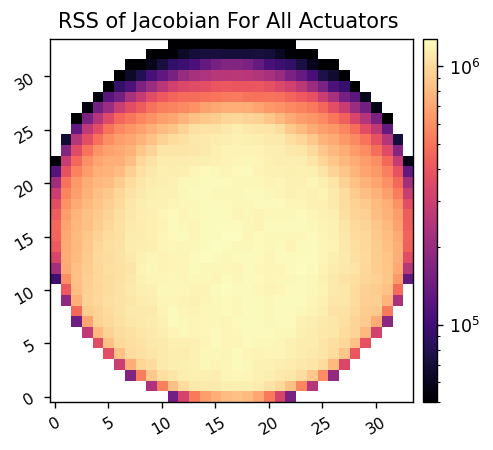

In [7]:
responses = jac[::2] + 1j*jac[1::2]
response = xp.sqrt(xp.sum(abs(responses.dot(xp.array(poke_modes)))**2, axis=0)).reshape(model.Nact,model.Nact)
imshow1(response, 'RSS of Jacobian For All Actuators ', lognorm=True, vmin=5e4)

# Run EFC on the compact model with perfect E-Field estimation


In [18]:
model.reset_dm()

images = xp.array([model_im])
dm_commands = xp.array([model.get_dm()])

In [14]:
# import apra_pop_models.efc as efc
import apra_pop_models.efc_embedded as efc
reload(efc)

<module 'apra_pop_models.efc_embedded' from '/home/apra/Projects/apra-howfsc-models/apra_pop_models/efc_embedded.py'>

In [37]:
import subprocess


In [43]:
subprocess.Popen(["/home/apra/Projects/P5040/P5040_test_software/EFC/bin/EFC_local"])

<Popen: returncode: None args: ['/home/apra/Projects/P5040/P5040_test_softwa...>

In [9]:
reg = 1e-1
# control_matrix = efc_utils.TikhonovInverse(jac, rcond=reg)
control_matrix = efc_utils.beta_reg(jac, -3)

Beginning closed-loop EFC.
	Running iteration 1/20.
Using model to compute electric field


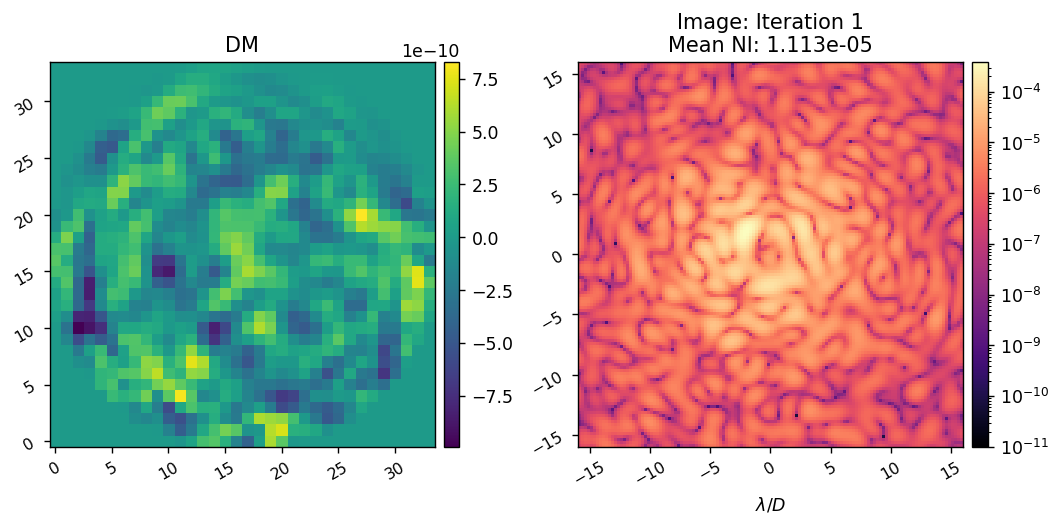

	Running iteration 2/20.
Using model to compute electric field


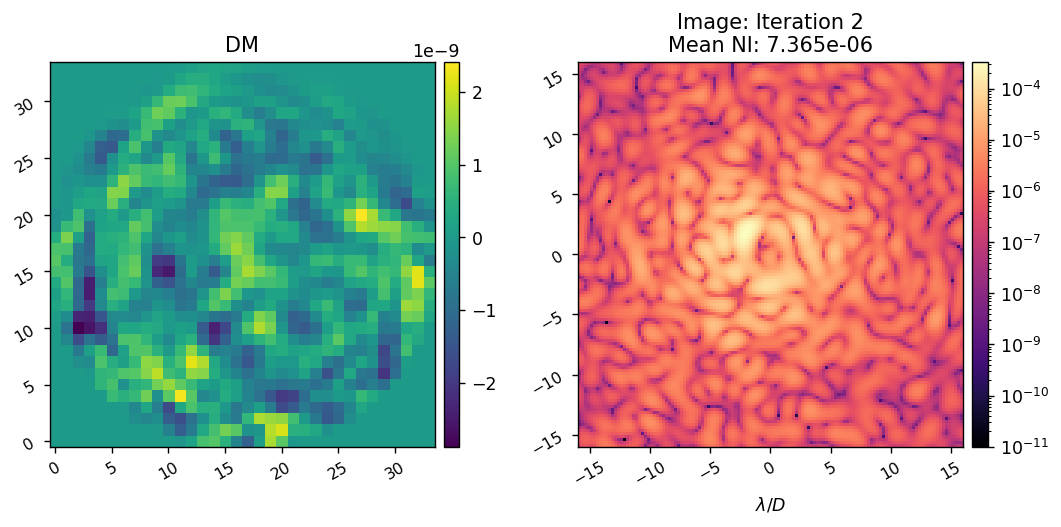

	Running iteration 3/20.
Using model to compute electric field


Exception ignored in: <function EmbeddedController.__del__ at 0x7ff2bed7c180>
Traceback (most recent call last):
  File "/home/apra/Projects/P5040/P5040_test_software/EFC/python_host/efc_host_utils.py", line 145, in __del__
    self.close()
  File "/home/apra/Projects/P5040/P5040_test_software/EFC/python_host/efc_host_utils.py", line 140, in close
    self.stop()
  File "/home/apra/Projects/P5040/P5040_test_software/EFC/python_host/efc_host_utils.py", line 136, in stop
    self.send_command(Commands.STOP)
  File "/home/apra/Projects/P5040/P5040_test_software/EFC/python_host/efc_host_utils.py", line 72, in send_command
    self.send_and_check_ack(struct.pack(COMMAND_TYPE,command.value))
  File "/home/apra/Projects/P5040/P5040_test_software/EFC/python_host/efc_host_utils.py", line 65, in send_and_check_ack
    raise Exception("Acknowledgment not received or invalid acknowledgment.")
Exception: Acknowledgment not received or invalid acknowledgment.
Exception ignored in: <function Embedded

Close was called
Close was called


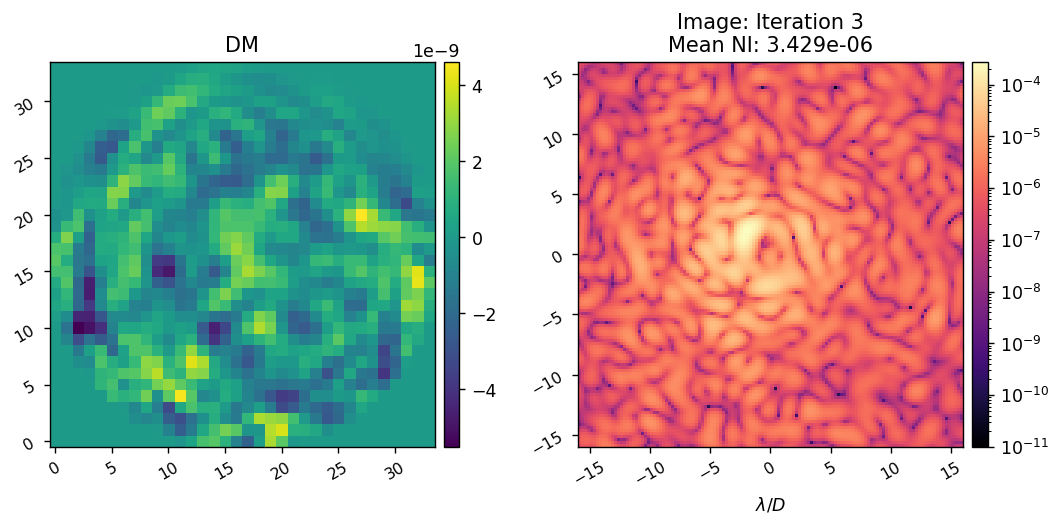

	Running iteration 4/20.
Using model to compute electric field


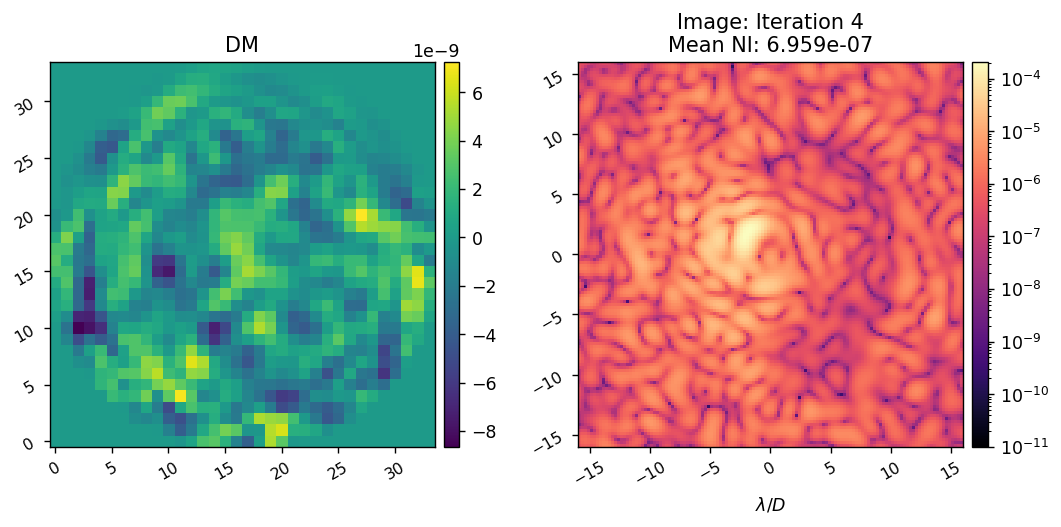

	Running iteration 5/20.
Using model to compute electric field


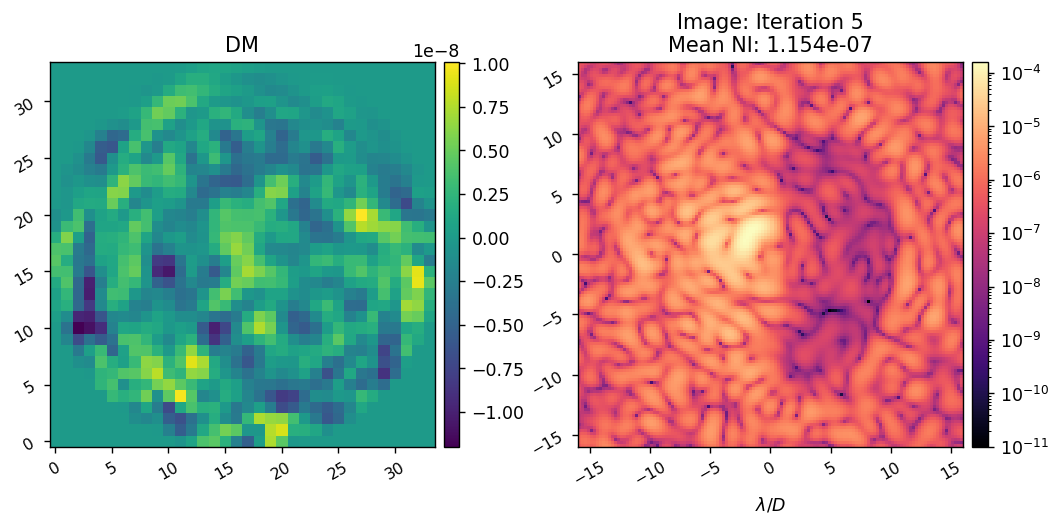

	Running iteration 6/20.
Using model to compute electric field


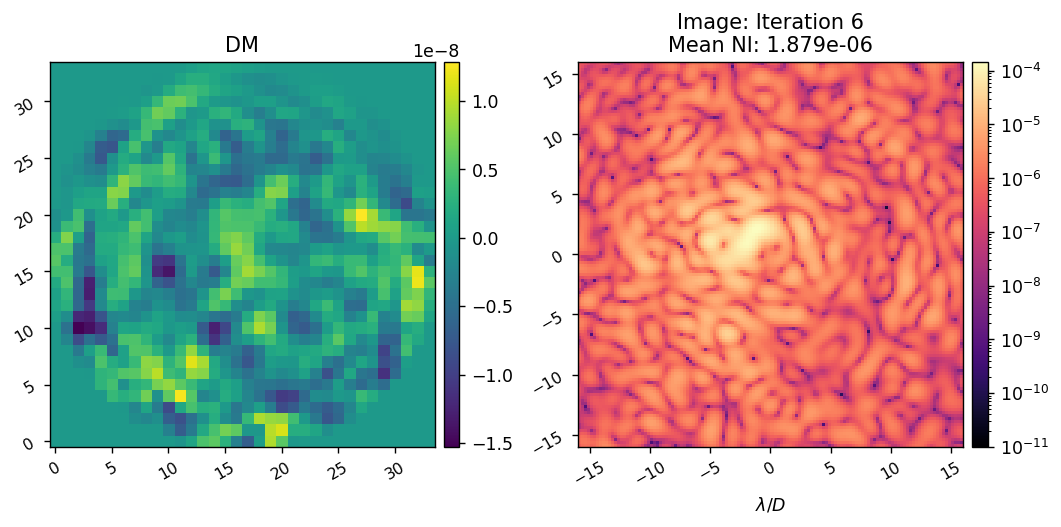

	Running iteration 7/20.
Using model to compute electric field


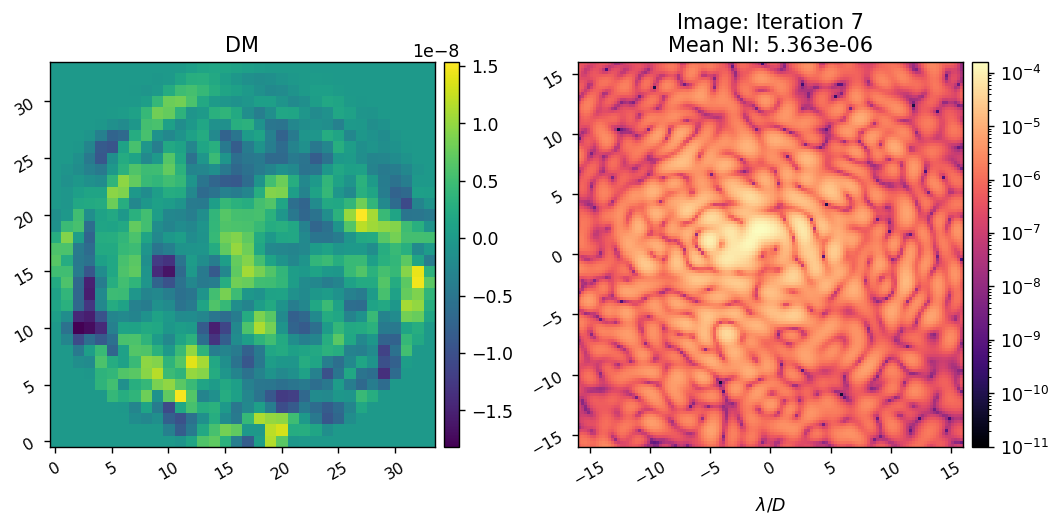

	Running iteration 8/20.
Using model to compute electric field


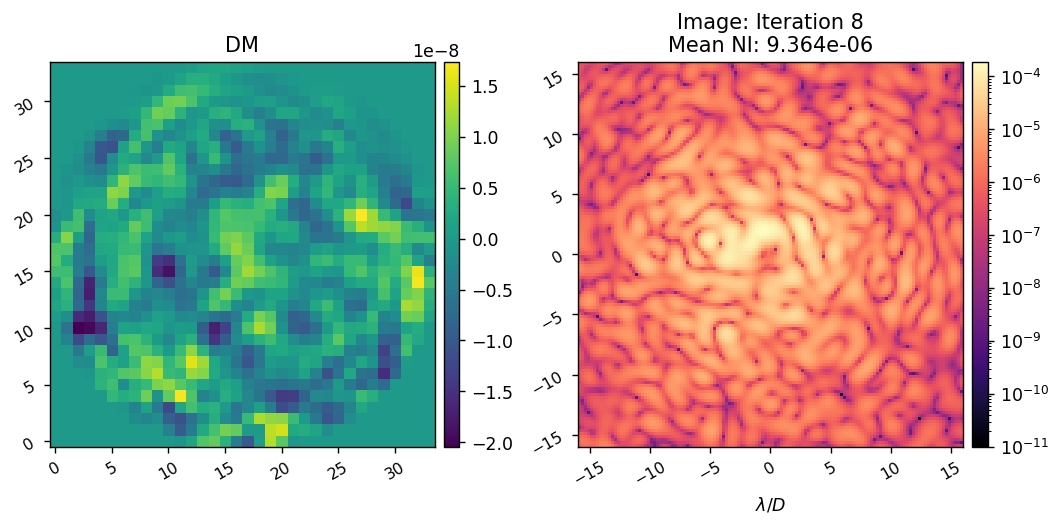

	Running iteration 9/20.
Using model to compute electric field


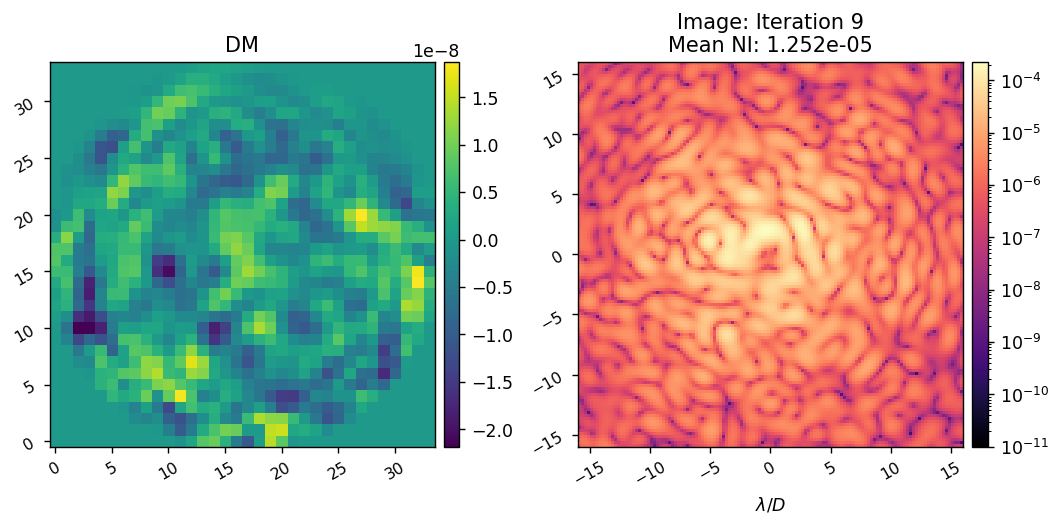

	Running iteration 10/20.
Using model to compute electric field


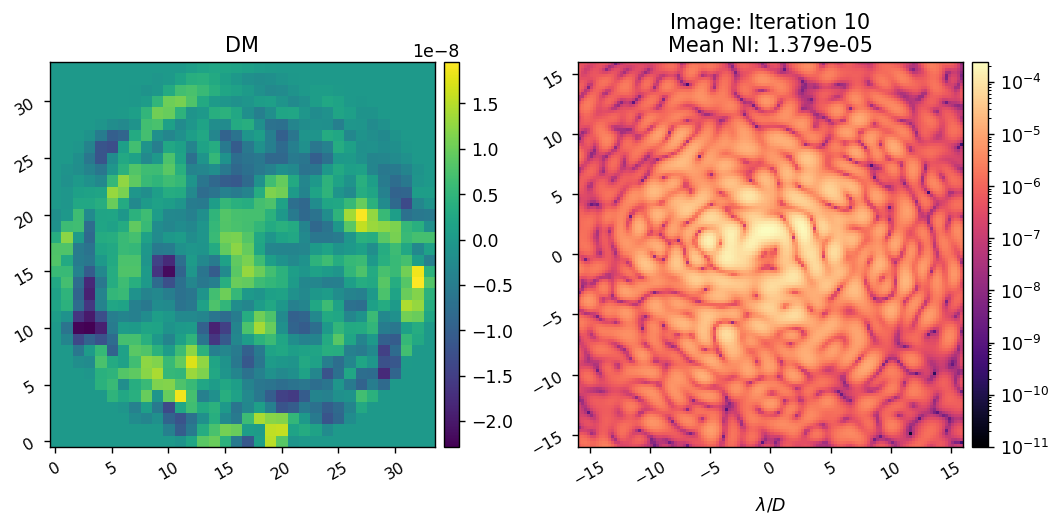

	Running iteration 11/20.
Using model to compute electric field


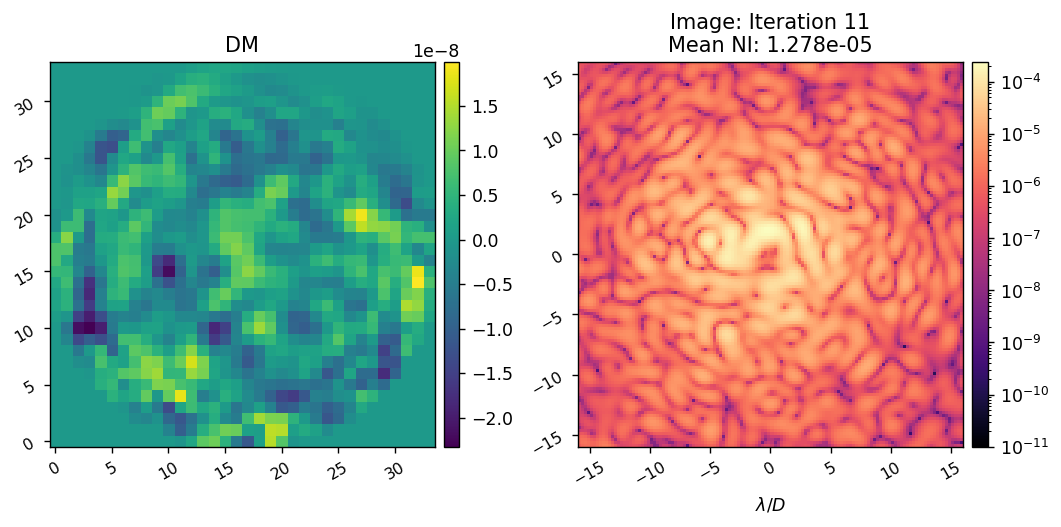

	Running iteration 12/20.
Using model to compute electric field


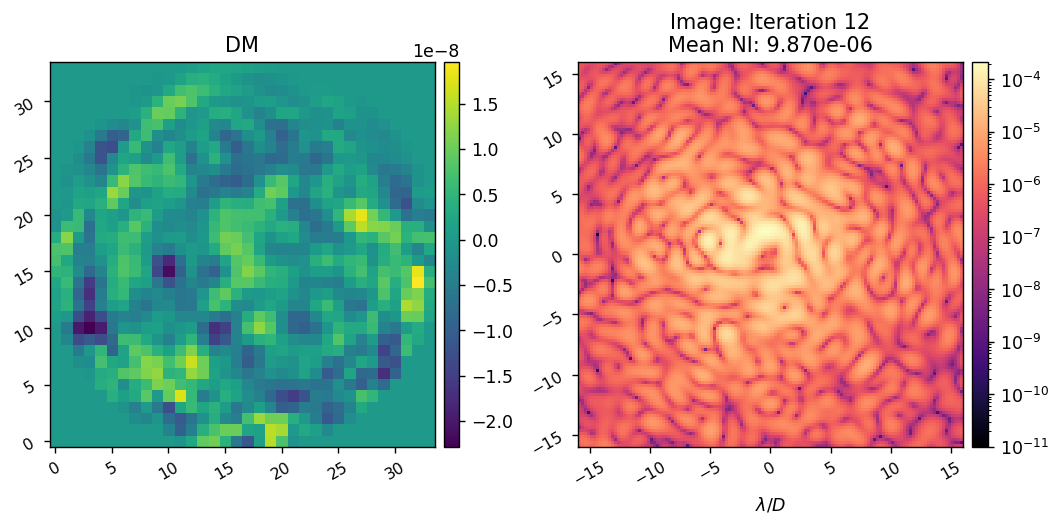

	Running iteration 13/20.
Using model to compute electric field


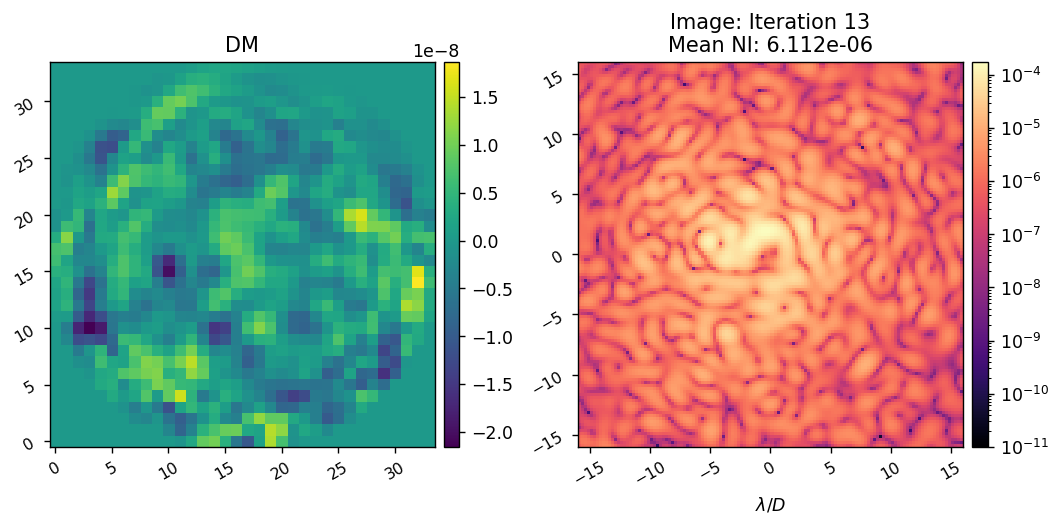

	Running iteration 14/20.
Using model to compute electric field


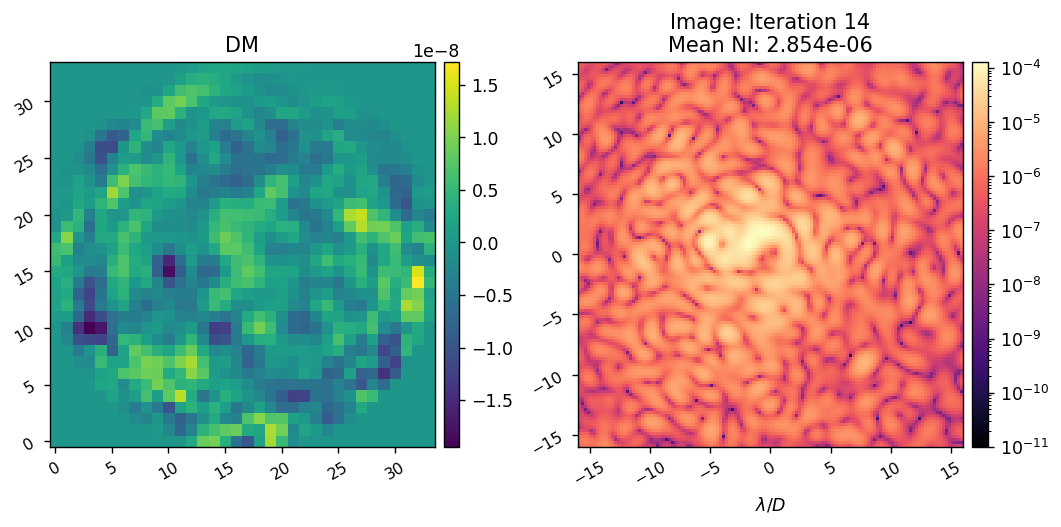

	Running iteration 15/20.
Using model to compute electric field


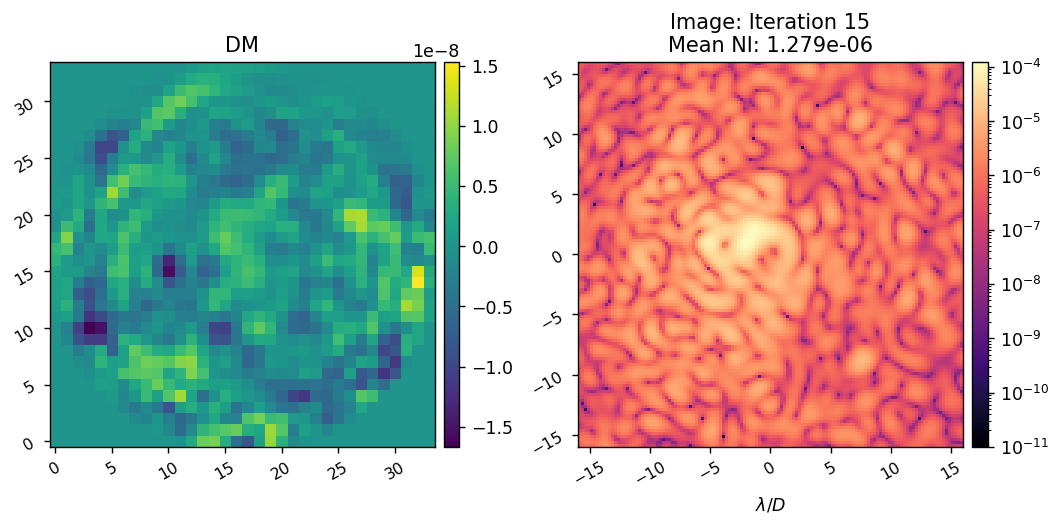

	Running iteration 16/20.
Using model to compute electric field


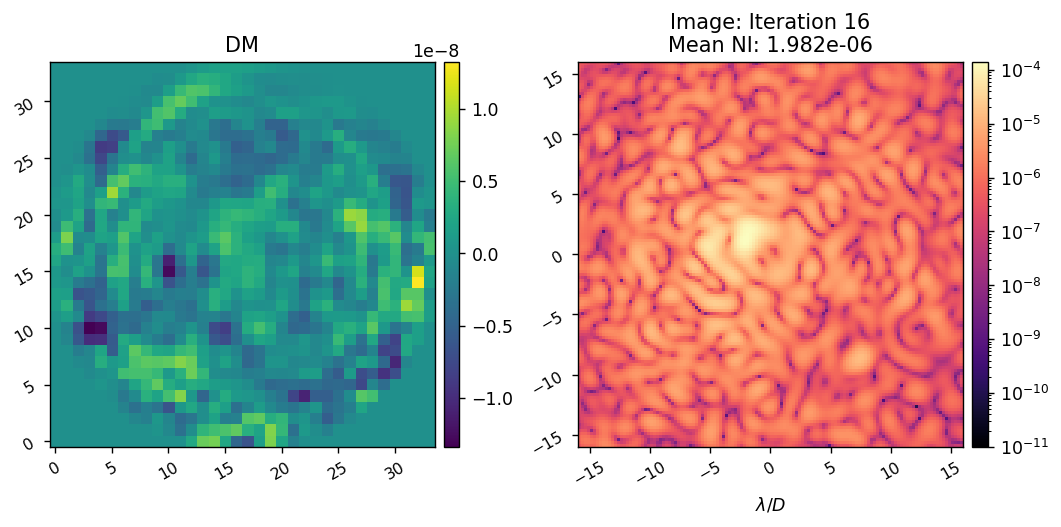

	Running iteration 17/20.
Using model to compute electric field


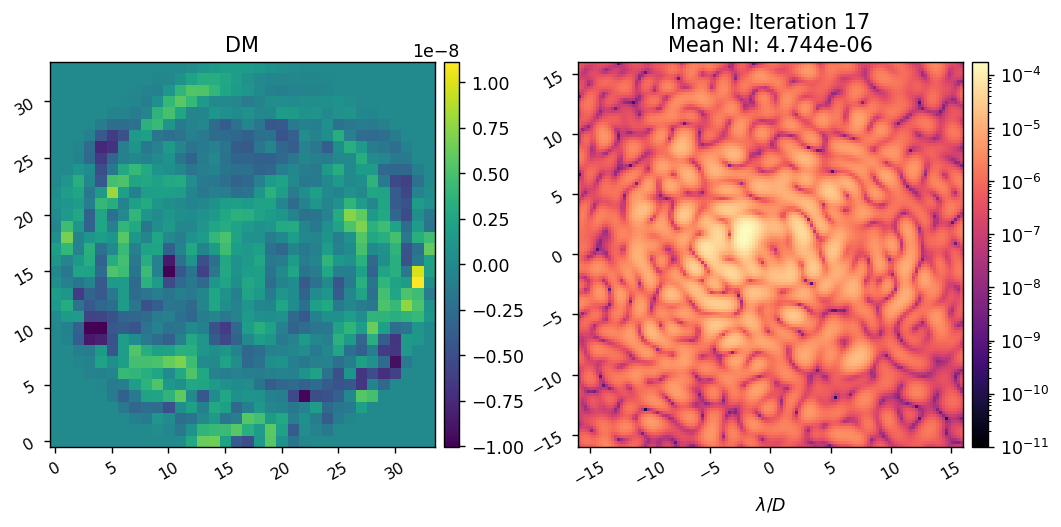

	Running iteration 18/20.
Using model to compute electric field


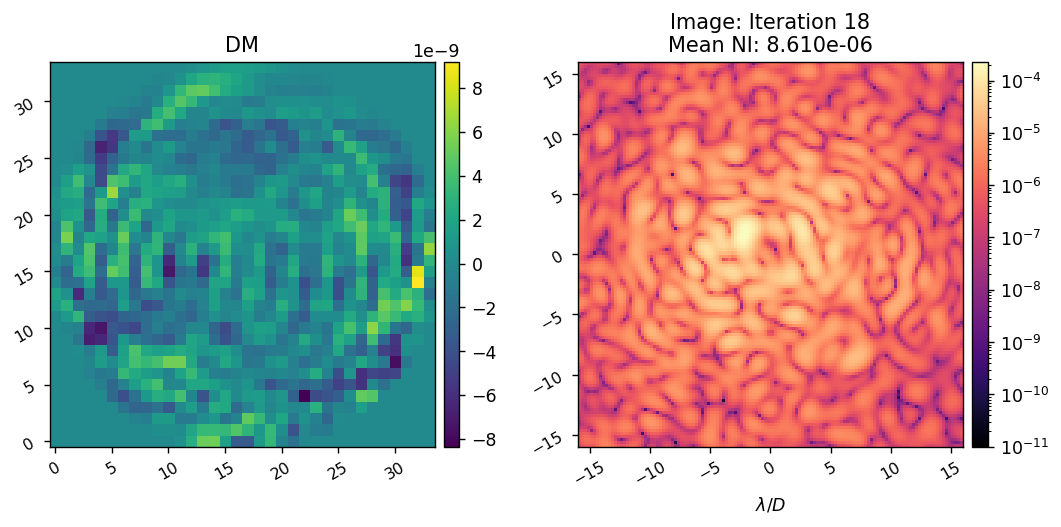

	Running iteration 19/20.
Using model to compute electric field


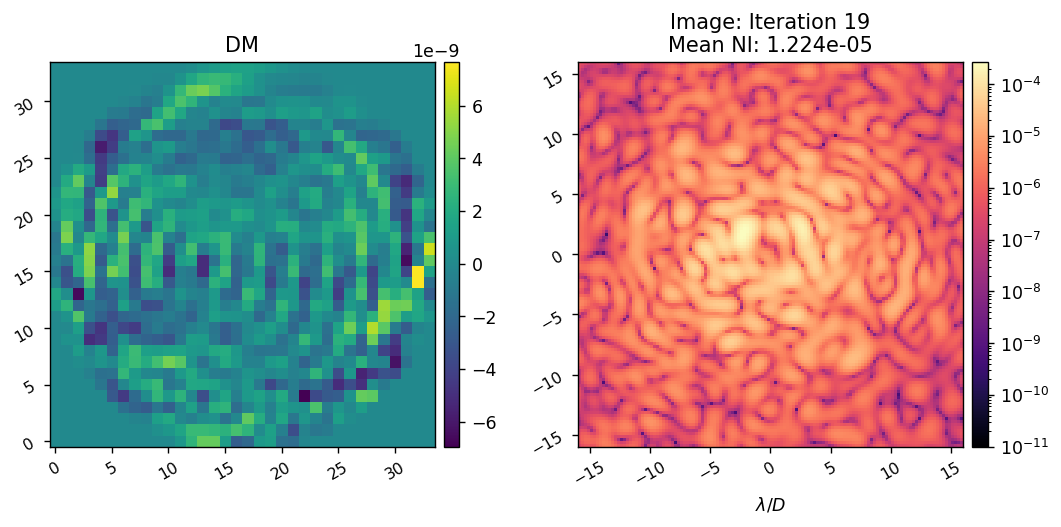

	Running iteration 20/20.
Using model to compute electric field


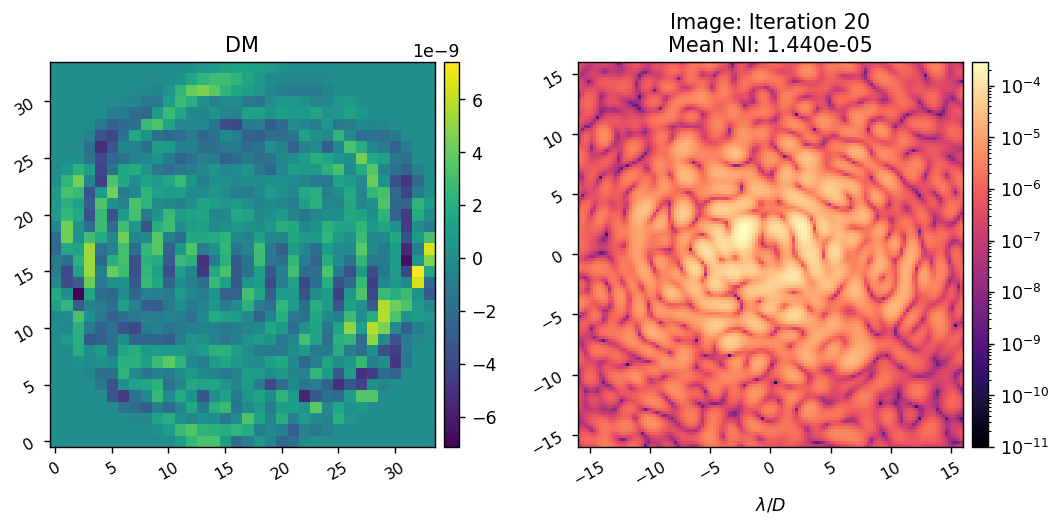

EFC completed in 78.618 sec.


In [19]:
reload(efc)
images, estimates, dm_commands = efc.run(model, 
                                         poke_modes,
                                         control_matrix,
                                         control_mask, 
                                        # est_fun=pwp_fun,
                                        # est_params=pwp_params,
                                        loop_gain=0.1, 
                                        leakage=0.0,
                                        iterations=20, 
                                        plot_all=True, 
                                        plot_current=True,
                                        plot_sms=False,
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        # old_fields=estimates,
                                        old_commands=dm_commands,
                                            )